In [1]:
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
import numpy as np
import metrics
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
import datetime as dt
def list_dates(start = '2017-08-23', end = '2017-08-23', window_size=28):
    delta = (dt.datetime.strptime(end, '%Y-%m-%d') - dt.datetime.strptime(start, '%Y-%m-%d')).days
    dates=[]
    for i in range(delta+window_size):
        dates.append(dt.datetime.strptime(start, '%Y-%m-%d') - dt.timedelta(days=window_size) + dt.timedelta(days=i))
    return np.asarray(dates)    

In [3]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [31]:
def rescale(df, data):
    true = df['True'].values
    pred = df['Pred'].values

    true =  data.scaler.inverse_transform(np.tile(true, (255,1)).T)[:,-1]
    pred =  data.scaler.inverse_transform(np.tile(pred, (255,1)).T)[:,-1]
    unscaled = pd.DataFrame(index=y_pred.index)
    unscaled['True'] = true
    unscaled['Pred'] = pred

    try:
        var = np.sqrt(y_pred['Std'].values)
        var =  data.scaler.inverse_transform(np.tile(var, (255,1)).T)[:,-1]
        unscaled['Std'] = np.square(var)
    except:
        pass
    return(unscaled)

In [4]:
def harmonic_smoothing(df, n=7):
    data = df.values
    for i in range(data.shape[0]):
        for j in range(data.shape[1]-1, n, -1):
            s = 1
            for k in range(1,n):
                data[i, j] = data[i,j] + data[i,j-n]/(k+1)
                s = s + 1/(k+1)
            data[i, j] = data[i,j]/s
            
    df = pd.DataFrame(columns = df.columns, index=df.index[-data.shape[0]:], data=data)
    return df

In [5]:
import datetime as dt
class data_builder_new:
    def __init__(self, root,country='eng'):
        self.directory = root

    def window(self, data, window_size=28):
        windowed = []
        for i in range(1+data.shape[0] - window_size):
            windowed.append(data[i:i + window_size])
        windowed = np.asarray(windowed)
        return windowed

    def build(self, test_year=2017, validation_year=2016, start_of_season = '-08-23', gamma=21, lag=7, window_size=28, smooth=True):
            
            if smooth:
                Qs = pd.read_csv(self.directory + 'google_queries_pre_processed_us_smooth.csv', 
                                 index_col=0, 
                                 parse_dates=True)
            else:
                Qs = pd.read_csv(self.directory + 'google_queries_pre_processed_us.csv', 
                                 index_col=0, 
                                 parse_dates=True)
            
            ILI = pd.read_csv('/home/mimorris/Datasets/Flu/ILI_rates_US_wednesday_linear_interpolation.csv', 
                              parse_dates=True)
            ILI = ILI.set_index('date')
            ILI.index = pd.to_datetime(ILI.index)
            
            Qs = Qs[:ILI.index[-1]]
            ILI.index = ILI.index + dt.timedelta(days=lag)
            Qs['ILI'] = ILI.loc[Qs.index[0]:Qs.index[-1]]
            
            self.scaler = MinMaxScaler()
            self.scaler.fit(Qs)
            
            window_size=window_size-1
            
            Qs = pd.DataFrame(index=Qs.index, columns=Qs.columns, data=self.scaler.transform(Qs))
            
            validation_index = list_dates(start=str(validation_year)+start_of_season, 
                                          end=str(validation_year+1)+start_of_season, 
                                          window_size=window_size)
            
            test_index = list_dates(start=str(test_year)+start_of_season, 
                                    end=str(test_year+1)+start_of_season,
                                    window_size=window_size)
            
            train_index = list_dates(start=dt.datetime.strftime(Qs.index[gamma+window_size], '%Y-%m-%d'), 
                                     end=str(validation_year)+start_of_season,
                                     window_size=window_size)
            
            x_train = Qs.loc[train_index - dt.timedelta(days=gamma)]
            x_val = Qs.loc[validation_index - dt.timedelta(days=gamma)]
            x_test = Qs.loc[test_index - dt.timedelta(days=gamma)]
            
            y_train = Qs.loc[(train_index + dt.timedelta(days=lag))[window_size:]]['ILI']
            y_val = Qs.loc[(validation_index + dt.timedelta(days=lag))[window_size:]]['ILI']
            y_test = Qs.loc[(test_index + dt.timedelta(days=lag))[window_size:]]['ILI']
            
            x_train = self.window(x_train, window_size=window_size+1)
            x_val = self.window(x_val, window_size=window_size+1)
            x_test = self.window(x_test, window_size=window_size+1)
            
            
            return x_train, y_train, x_val, y_val, x_test, y_test

In [19]:
importlib.reload(model)

args = Namespace(Arch='FF', Ext='-c', early_stopping=False, smooth=True, Batch_Size=64, Epochs=200, Gamma=14, country='us', )
data = data_builder_new(root="/home/mimorris/Datasets/Flu/", 
                        country = 'us')
val_predictions=pd.DataFrame()
test_predictions=pd.DataFrame()
             
year = 0
x_train, y_train, x_val, y_val, x_test, y_test = data.build(test_year=2014+year, 
                                                            validation_year=2013+year, 
                                                            start_of_season = '-08-23', 
                                                            gamma=args.Gamma, 
                                                            lag=7, 
                                                            window_size=28,
                                                            smooth=args.smooth)
tf.keras.backend.clear_session()
NN = model.model_builder(x_train, y_train[:, np.newaxis], args=args)         
NN.fit(x_train, y_train[:, np.newaxis])

<ipython-input-19-bc253682f444>:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  NN = model.model_builder(x_train, y_train[:, np.newaxis], args=args)
<ipython-input-19-bc253682f444>:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  NN.fit(x_train, y_train[:, np.newaxis])


Epoch 1/200
55/55 [==============================] - 1s 4ms/step - Loss: 2.0328 - Likelihood: 1.9232 - KL: 0.1095
Epoch 2/200
55/55 [==============================] - 0s 3ms/step - Loss: 1.4704 - Likelihood: 1.4202 - KL: 0.0502
Epoch 3/200
55/55 [==============================] - 0s 3ms/step - Loss: 0.8403 - Likelihood: 0.7805 - KL: 0.0599
Epoch 4/200
55/55 [==============================] - 0s 3ms/step - Loss: 0.3525 - Likelihood: 0.2797 - KL: 0.0728
Epoch 5/200
55/55 [==============================] - 0s 3ms/step - Loss: 0.1022 - Likelihood: 0.0107 - KL: 0.0915
Epoch 6/200
55/55 [==============================] - 0s 3ms/step - Loss: -0.1783 - Likelihood: -0.2885 - KL: 0.1102
Epoch 7/200
55/55 [==============================] - 0s 3ms/step - Loss: -0.3330 - Likelihood: -0.4620 - KL: 0.1290
Epoch 8/200
55/55 [==============================] - 0s 3ms/step - Loss: -0.5756 - Likelihood: -0.7170 - KL: 0.1414
Epoch 9/200
55/55 [==============================] - 0s 3ms/step - Loss: -0.7086 -

55/55 [==============================] - 0s 4ms/step - Loss: -0.6223 - Likelihood: -0.8706 - KL: 0.2483
Epoch 72/200
55/55 [==============================] - 0s 3ms/step - Loss: -0.6503 - Likelihood: -0.8967 - KL: 0.2464A: 0s - Loss: -0.6203 - Likelihood: -0.8666 - KL: 0.2
Epoch 73/200
55/55 [==============================] - 0s 3ms/step - Loss: -0.7665 - Likelihood: -1.0121 - KL: 0.2456
Epoch 74/200
55/55 [==============================] - 0s 3ms/step - Loss: -0.8397 - Likelihood: -1.0858 - KL: 0.2461
Epoch 75/200
55/55 [==============================] - 0s 3ms/step - Loss: -0.8562 - Likelihood: -1.1004 - KL: 0.2442
Epoch 76/200
55/55 [==============================] - 0s 4ms/step - Loss: -0.8908 - Likelihood: -1.1347 - KL: 0.2440
Epoch 77/200
55/55 [==============================] - 0s 3ms/step - Loss: -0.9188 - Likelihood: -1.1602 - KL: 0.2414
Epoch 78/200
55/55 [==============================] - 0s 4ms/step - Loss: -0.9558 - Likelihood: -1.1985 - KL: 0.2427
Epoch 79/200
55/55 [====

55/55 [==============================] - 0s 4ms/step - Loss: -1.7052 - Likelihood: -1.9233 - KL: 0.2181
Epoch 141/200
55/55 [==============================] - 0s 3ms/step - Loss: -1.7473 - Likelihood: -1.9670 - KL: 0.2197
Epoch 142/200
55/55 [==============================] - 0s 3ms/step - Loss: -1.7562 - Likelihood: -1.9712 - KL: 0.2150
Epoch 143/200
55/55 [==============================] - 0s 3ms/step - Loss: -1.7280 - Likelihood: -1.9483 - KL: 0.2203
Epoch 144/200
55/55 [==============================] - 0s 4ms/step - Loss: -1.7820 - Likelihood: -1.9982 - KL: 0.2162
Epoch 145/200
55/55 [==============================] - 0s 3ms/step - Loss: -1.7826 - Likelihood: -2.0039 - KL: 0.2213
Epoch 146/200
55/55 [==============================] - 0s 4ms/step - Loss: -1.7021 - Likelihood: -1.9208 - KL: 0.2186
Epoch 147/200
55/55 [==============================] - 0s 4ms/step - Loss: -1.7600 - Likelihood: -1.9788 - KL: 0.2188
Epoch 148/200
55/55 [==============================] - 0s 3ms/step - L

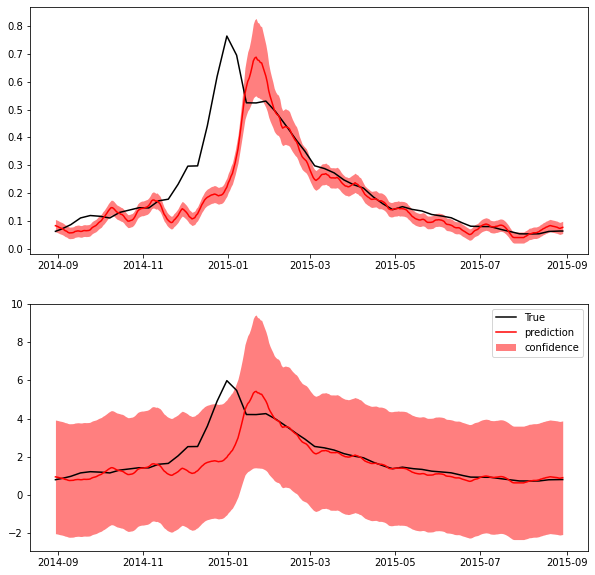

In [45]:
y_pred = NN.predict(x_test, pd.DataFrame(index=y_test.index, data=y_test.values, columns=['T0']))
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(y_pred.index,y_pred['True'], color='black', label='True')
plt.plot(y_pred.index, 
         y_pred['Pred'],
         color='red',
         label='prediction')
try:
    plt.fill_between(y_pred.index, 
                     y_pred['Pred']-y_pred['Std'],
                     y_pred['Pred']+y_pred['Std'], 
                     color='red', 
                     alpha=0.5,
                     linewidth=0,
                     label='confidence')
except:
    pass

plt.subplot(2,1,2)
y_pred = rescale(y_pred, data)
plt.plot(y_pred.index,y_pred['True'], color='black', label='True')
plt.plot(y_pred.index, 
         y_pred['Pred'],
         color='red',
         label='prediction')
try:
    plt.fill_between(y_pred.index, 
                     y_pred['Pred']-y_pred['Std'],
                     y_pred['Pred']+y_pred['Std'], 
                     color='red', 
                     alpha=0.5,
                     linewidth=0,
                     label='confidence')
except:
    pass
plt.legend()
plt.show()

In [44]:
def rescale(df, data):
    unscaled = pd.DataFrame(index=y_pred.index)
    
    true = df['True'].values
    true = data.scaler.inverse_transform(np.tile(true, (255,1)).T)[:,-1]
    unscaled['True'] = true
    
    pred = df['Pred'].values
    pred = data.scaler.inverse_transform(np.tile(pred, (255,1)).T)[:,-1]
    unscaled['Pred'] = pred

    try:
        std = y_pred['Std'].values
        std = data.scaler.inverse_transform(np.tile(var, (255,1)).T)[:,-1]
        unscaled['Std'] = std
    except:
        pass
    return(unscaled)

,True,Pred,Std
2014-08-30,0.808148,0.957099,0.596014
2014-08-31,0.821655,0.944039,0.595986
2014-09-01,0.835162,0.927443,0.595950
2014-09-02,0.848669,0.905933,0.595904
2014-09-03,0.862176,0.892296,0.595876
...,...,...,...
2015-08-25,0.815273,0.915705,0.595925
2015-08-26,0.816943,0.896200,0.595884
2015-08-27,0.816597,0.884598,0.595860
2015-08-28,0.816250,0.897698,0.595887


In [48]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

args_list = [Namespace(Batch_Size=64, Epochs=200, Gamma=14, country='us', early_stopping=False, smooth=True),
             Namespace(Batch_Size=64, Epochs=200, Gamma=14, country='us', early_stopping=False, smooth=False),
             Namespace(Batch_Size=64, Epochs=200, Gamma=14, country='us', early_stopping=True, smooth=True),
             Namespace(Batch_Size=64, Epochs=200, Gamma=14, country='us', early_stopping=True, smooth=False)]

results_val=[]
results_test=[]
    
data = data_builder_new(root="/home/mimorris/Datasets/Flu/", 
                        country = 'us')
val_predictions=pd.DataFrame()
test_predictions=pd.DataFrame()
for args in args_list[:1]:

    results_val.append(pd.DataFrame(index = ['CRPS','NLL','MAE','RMSE','SMAPE','Corr','MB Log','SDP']))
    results_test.append(pd.DataFrame(index = ['CRPS','NLL','MAE','RMSE','SMAPE','Corr','MB Log','SDP']))
    
    for year in range(4):
        x_train, y_train, x_val, y_val, x_test, y_test = data.build(test_year=2014+year, 
                                                                validation_year=2013+year, 
                                                                start_of_season = '-08-23', 
                                                                gamma=args.Gamma, 
                                                                lag=7, 
                                                                window_size=28,
                                                                smooth=args.smooth)

        tf.keras.backend.clear_session()
        NN = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(1)
#             , kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-3, l2=1e-3))
        ])

        NN.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005), loss='mse')

        if args.early_stopping:
            callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss', min_delta=0, patience=25, verbose=0,
                    mode='auto', baseline=None, restore_best_weights=True
            )]
        else:
            callbacks=None

        NN.fit(x_train, y_train, 
                  shuffle=True,
                  validation_data=(x_val,y_val),
                  epochs=args.Epochs,
                  verbose=0,
                  callbacks=callbacks)

        loss=tf.keras.losses.mean_squared_error
        
   
        y_pred_test = data.scaler.inverse_transform(np.tile(model.predict(x_test).squeeze(), (255,1)).T)[:,-1]
        y_pred_val = data.scaler.inverse_transform(np.tile(model.predict(x_val).squeeze(), (255,1)).T)[:,-1]
        
        
        y_val_unscaled = data.scaler.inverse_transform(np.tile(y_val, (255,1)).T)[:,-1]
        y_test_unscaled = data.scaler.inverse_transform(np.tile(y_test, (255,1)).T)[:,-1]
#         y_pred_test = model.predict(x_test)
#         y_pred_val = model.predict(x_val)
        
        
        pred = pd.DataFrame(index=y_val.index)
        pred['True'] = y_val_unscaled
        pred['Pred'] = y_pred_val
        val_predictions = val_predictions.append(pred)
        results_val[-1][str(year + 2014) + '/' + str(year + 15)] = [metrics.crps(pred),
                                                                metrics.nll(pred),
                                                                metrics.mae(pred),
                                                                metrics.rmse(pred),
                                                                metrics.smape(pred),
                                                                metrics.corr(pred),
                                                                metrics.mb_log(pred),
                                                                metrics.sdp(pred)]
        
        
        pred = pd.DataFrame(index=y_test.index)
        pred['True'] = y_test_unscaled
        pred['Pred'] = y_pred_test
        test_predictions = test_predictions.append(pred)
        results_test[-1][str(year + 2014) + '/' + str(year + 15)] = [metrics.crps(pred),
                                                                metrics.nll(pred),
                                                                metrics.mae(pred),
                                                                metrics.rmse(pred),
                                                                metrics.smape(pred),
                                                                metrics.corr(pred),
                                                                metrics.mb_log(pred),
                                                                metrics.sdp(pred)]
                
    results_val[-1]['Average'] = results_val[-1].mean(1)
    results_val[-1]['Average'].loc['SDP'] = np.abs(results_val[-1].loc['SDP'].values[-1]).mean()
    results_test[-1]['Average'] = results_test[-1].mean(1)
    results_test[-1]['Average'].loc['SDP'] = np.abs(results_test[-1].loc['SDP'].values[-1]).mean()

In [21]:
pred

NameError: name 'pred' is not defined

In [49]:
results_val[-1]['Average'] = results_val[-1].mean(1)
results_val[-1]['Average'].loc['SDP'] = np.abs(results_val[-1].loc['SDP'].values[-1]).mean()
results_test[-1]['Average'] = results_test[-1].mean(1)
results_test[-1]['Average'].loc['SDP'] = np.abs(results_test[-1].loc['SDP'].values[-1]).mean()

In [50]:
results_test[-1]

,2014/15,2015/16,2016/17,2017/18,Average
CRPS,NaN,NaN,NaN,NaN,NaN
NLL,NaN,NaN,NaN,NaN,NaN
MAE,0.373907,0.257696,0.335118,0.554806,0.380382
RMSE,0.744047,0.383076,0.580044,0.917892,0.656265
SMAPE,7.796253,7.088748,7.377365,8.524820,7.696797
Corr,0.857833,0.871146,0.897114,0.888973,0.878767
MB Log,NaN,NaN,NaN,NaN,NaN
SDP,-14.000000,53.000000,-17.000000,-19.000000,0.750000


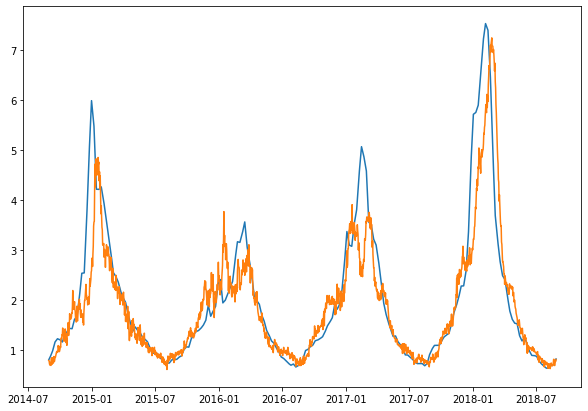

In [51]:
plt.figure(figsize=(10,7))
plt.plot(test_predictions.index, test_predictions['True'])
plt.plot(test_predictions.index, test_predictions['Pred'])
plt.show()

# plt.plot(val_predictions.index, val_predictions['True'])
# plt.plot(val_predictions.index, val_predictions['Pred'])
# plt.show()

In [296]:
for idx, res in enumerate(results):
    print(' ')
    print(res)

 
          2014/15    2015/16    2016/17    2017/18    Average
CRPS          NaN        NaN        NaN        NaN        NaN
NLL           NaN        NaN        NaN        NaN        NaN
MAE      0.051029   0.051389   0.039457   0.044842   0.046679
RMSE     0.082700   0.088928   0.056078   0.072119   0.074957
SMAPE   11.600243  11.483100   9.956986  10.437889  10.869554
Corr     0.774650   0.869855   0.853237   0.904125   0.850467
MB Log        NaN        NaN        NaN        NaN        NaN
SDP    -20.000000 -18.000000  63.000000 -18.000000   1.750000
 
          2014/15    2015/16   2016/17    2017/18    Average
CRPS          NaN        NaN       NaN        NaN        NaN
NLL           NaN        NaN       NaN        NaN        NaN
MAE      0.047824   0.051092  0.035971   0.048069   0.045739
RMSE     0.081379   0.089512  0.052557   0.071014   0.073616
SMAPE   11.434754  11.701312  9.002654  11.767404  10.976531
Corr     0.772643   0.862998  0.868116   0.905325   0.852271
MB Log     

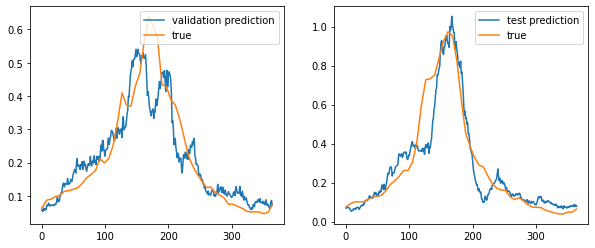

In [247]:
args_list[0].

